In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 34.3 MB/s 


In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
raw = mne.io.read_raw_brainvision("/content/drive/MyDrive/EEG Dataset/sub-010003.vhdr", preload=True)
raw.get_data().shape

Extracting parameters from /content/drive/MyDrive/EEG Dataset/sub-010003.vhdr...
Setting channel info structure...
Reading 0 ... 2519849  =      0.000 ...  1007.940 secs...


(62, 2519850)

Setting up low-pass filter at 50 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 50.00 Hz: -6.02 dB

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


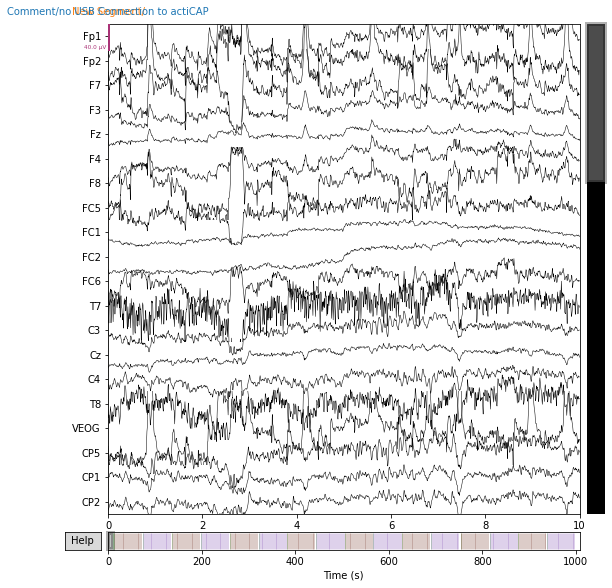

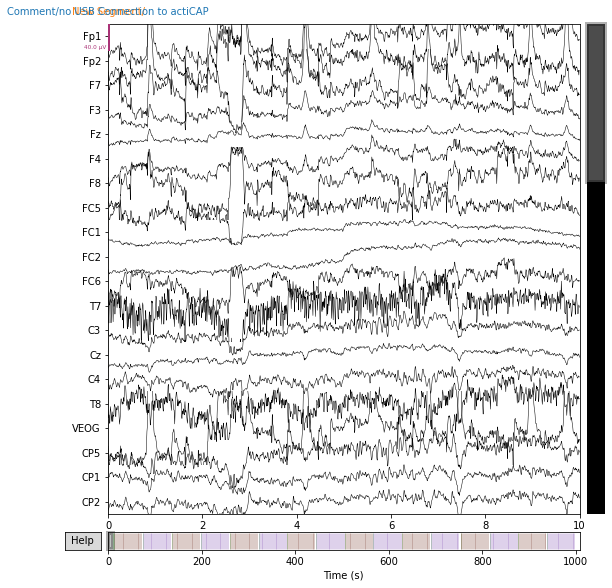

In [ ]:
raw.plot(block=True, lowpass=50)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense,  Conv1D, Flatten, MaxPooling1D, Dropout, UpSampling1D
from tensorflow.keras.layers import Convolution2D
import numpy as np
import mne
import pickle
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import h5py
from random import shuffle
from keras.datasets import mnist

In [ ]:
batch_size = 128
nb_epoch = 100

# Parameters for mne dataset
channels_num = 62
encoding_dim = 32

In [ ]:
raw = mne.io.read_raw_brainvision("/content/drive/MyDrive/EEG Dataset/sub-010002.vhdr", preload=True)
data = raw.get_data().T
data.shape

Extracting parameters from /content/drive/MyDrive/EEG Dataset/sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...


(2555000, 62)

In [ ]:
#Build CNN Model

In [ ]:
def create_ae():
    filter_length = 5
    window_size = 1
    encoding_dim = 62
    input_ = Input(shape=(window_size, 62))
    encoder = Sequential((Conv1D(filters=62, kernel_size=3, activation='relu', padding='same', input_shape=(window_size, 62)),Dropout(0.4),MaxPooling1D(padding="same"),
                          Conv1D(filters=62, kernel_size=3, activation='relu', padding='same'),MaxPooling1D(padding="same"),Dense(encoding_dim, activation='relu')))
    encoder.summary()
    print(encoder.output_shape)
    decoder = Sequential((
    Conv1D(filters=62, kernel_size=3, activation='relu', padding='same', input_shape=encoder.output_shape[-2:]),
    UpSampling1D(),
    Conv1D(filters=62, kernel_size=3, padding='same', activation='relu'),
    UpSampling1D(),
    Conv1D(filters=62, kernel_size=3, padding='same', activation='sigmoid')
    ))
    decoder.summary()
    autoencoder = Model(input_, decoder(encoder(input_)), name="autoencoder")
    autoencoder.compile(loss='mse', optimizer='adam') # .compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.summary()
    
    return encoder, autoencoder

In [ ]:
enc_dim = 62
timestep = 1
hist_path = "train_hist.txt"
hist = [[],[]]

In [ ]:
encoder,autoencoder = create_ae()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 62)             11594     
                                                                 
 dropout (Dropout)           (None, 1, 62)             0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 62)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 62)             11594     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 62)            0         
 1D)                                                             
                                                                 
 dense (Dense)               (None, 1, 62)             3

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, _, _ = train_test_split(data, data, test_size=0.3)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape((len(X_train), 1, np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), 1, np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(1788500, 1, 62)
(766500, 1, 62)


In [ ]:
X_train_noise = X_train + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noise = np.clip(X_train_noise, 0., 1.)
X_test_noise = np.clip(X_test_noise, 0., 1.)
print(X_train_noise.shape)
print(X_test_noise.shape)

(1788500, 1, 62)
(766500, 1, 62)


In [ ]:
from IPython.display import clear_output
import keras

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metrics = [x for x in logs if 'val' not in x]
        print(len(metrics))
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs.plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs.plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs.legend()
            axs.grid()

        plt.tight_layout()
        plt.show()

AttributeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd878e345f0> (for post_execute):


KeyboardInterrupt: ignored

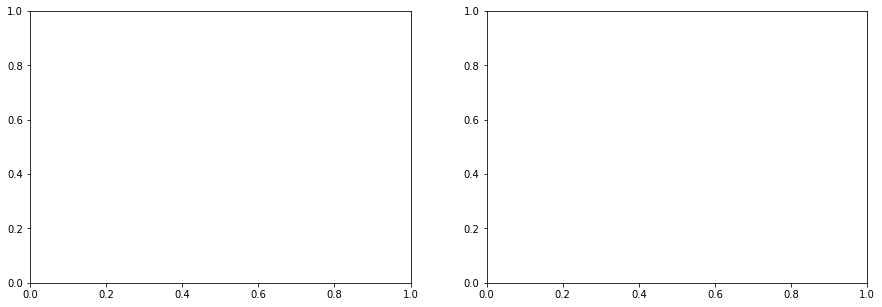

In [ ]:
callbacks_list = [PlotLearning()]
autoencoder.fit(X_train_noise, X_train, verbose=1,batch_size=128,epochs=100,callbacks=callbacks_list,validation_data=(X_test_noise, X_test))

In [ ]:
from sklearn.metrics import mean_squared_error
x_pred=autoencoder.predict(X_test)

In [ ]:
x_pred

array([[ 2.03229888e-07,  7.91876005e-08, -2.30175790e-08, ...,
         1.97526589e-07,  1.11529580e-07,  2.78803380e-08],
       [ 2.03229831e-07,  7.91875649e-08, -2.30175790e-08, ...,
         1.97526575e-07,  1.11529580e-07,  2.78803611e-08],
       [ 2.03229774e-07,  7.91876005e-08, -2.30175647e-08, ...,
         1.97526589e-07,  1.11529552e-07,  2.78803416e-08],
       ...,
       [ 2.03229675e-07,  7.91876573e-08, -2.30175985e-08, ...,
         1.97526660e-07,  1.11529495e-07,  2.78803984e-08],
       [ 2.03229888e-07,  7.91876289e-08, -2.30175647e-08, ...,
         1.97526603e-07,  1.11529580e-07,  2.78803611e-08],
       [ 2.03229831e-07,  7.91875436e-08, -2.30175932e-08, ...,
         1.97526546e-07,  1.11529552e-07,  2.78803274e-08]], dtype=float32)